In [99]:

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.rnn(x.unsqueeze(1))
        return self.fc_layers(out[:, -1, :])

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(1))
        return self.fc_layers(out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.gru(x.unsqueeze(1))
        return self.fc_layers(out[:, -1, :])

def train_dl_model(name, model_class, input_dim, X_train, X_test, y_train, y_test, epochs=100, batch_size=32):
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    model = model_class(input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
        scheduler.step()

        model.eval()
        with torch.no_grad():
            train_loss = criterion(model(X_train_t), y_train_t).item()
            test_loss = criterion(model(X_test_t), y_test_t).item()

        train_losses.append(train_loss)
        test_losses.append(test_loss)

    with torch.no_grad():
        preds = model(X_test_t).squeeze().numpy()
        actual = y_test_t.squeeze().numpy()

    metrics_df = pd.DataFrame({"epoch": list(range(1, epochs+1)), "train_loss": train_losses, "test_loss": test_losses})
    pred_df = pd.DataFrame({"Actual": actual, "Predicted": preds})
    metrics_path = f"../processed_data/{name.lower()}_metrics.csv"
    preds_path = f"../processed_data/{name.lower()}_predictions.csv"
    metrics_df.to_csv(metrics_path, index=False)
    pred_df.to_csv(preds_path, index=False)

    return metrics_path, preds_path, train_losses, test_losses

dl_models = {
    "stl_rnn": (RNNModel, stl_input_dim, stl_X_train, stl_X_test, stl_y_train, stl_y_test),
    "hp_rnn": (RNNModel, hp_input_dim, hp_X_train, hp_X_test, hp_y_train, hp_y_test),
    "stl_lstm": (LSTMModel, stl_input_dim, stl_X_train, stl_X_test, stl_y_train, stl_y_test),
    "hp_lstm": (LSTMModel, hp_input_dim, hp_X_train, hp_X_test, hp_y_train, hp_y_test),
    "stl_gru": (GRUModel, stl_input_dim, stl_X_train, stl_X_test, stl_y_train, stl_y_test),
    "hp_gru": (GRUModel, hp_input_dim, hp_X_train, hp_X_test, hp_y_train, hp_y_test),
}

results = {}
for name, (model_cls, dim, Xtr, Xte, ytr, yte) in dl_models.items():
    results[name] = train_dl_model(name, model_cls, dim, Xtr, Xte, ytr, yte)


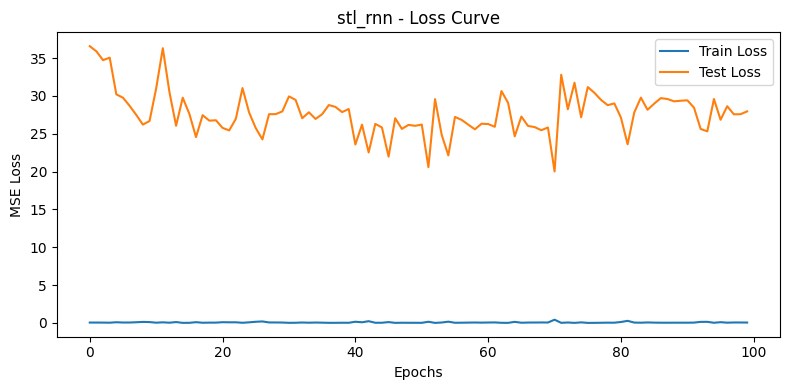

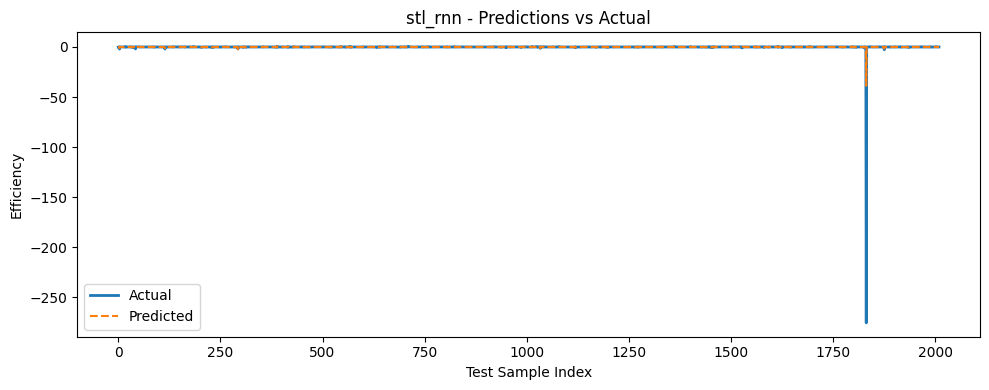

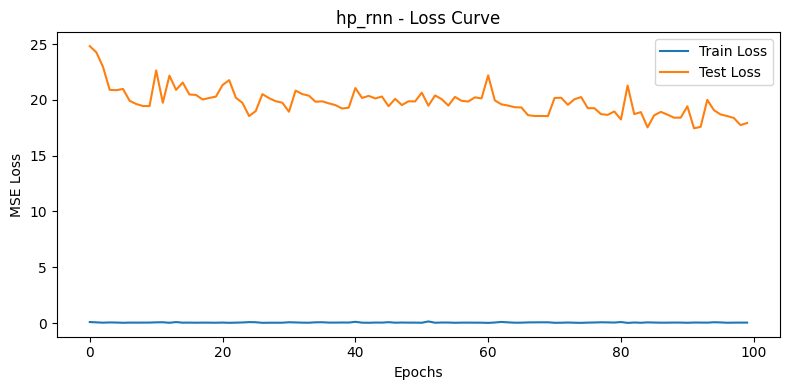

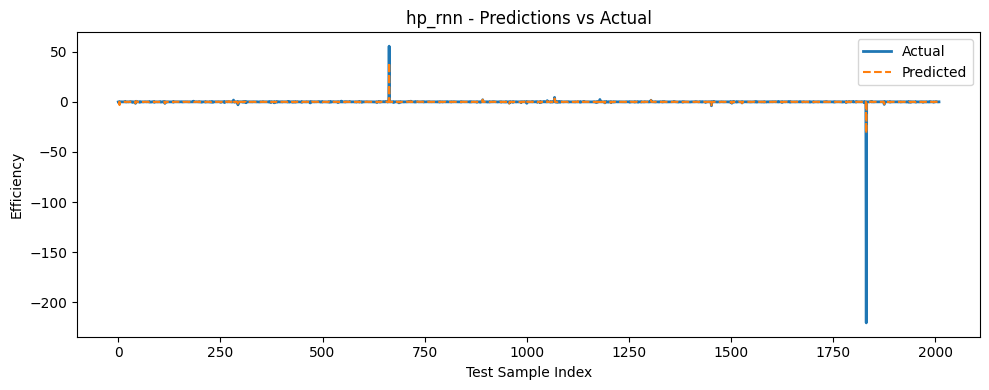

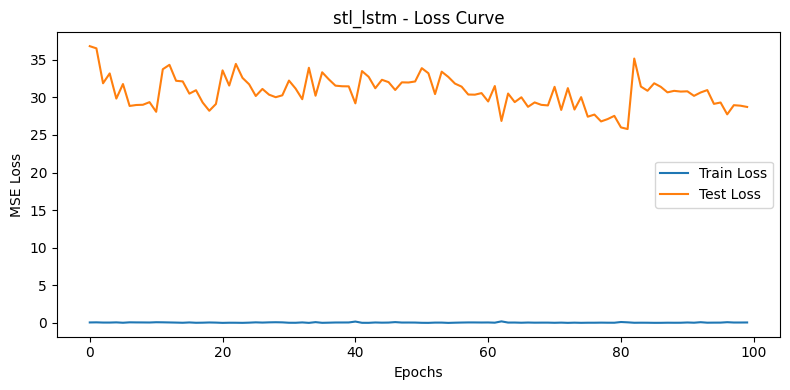

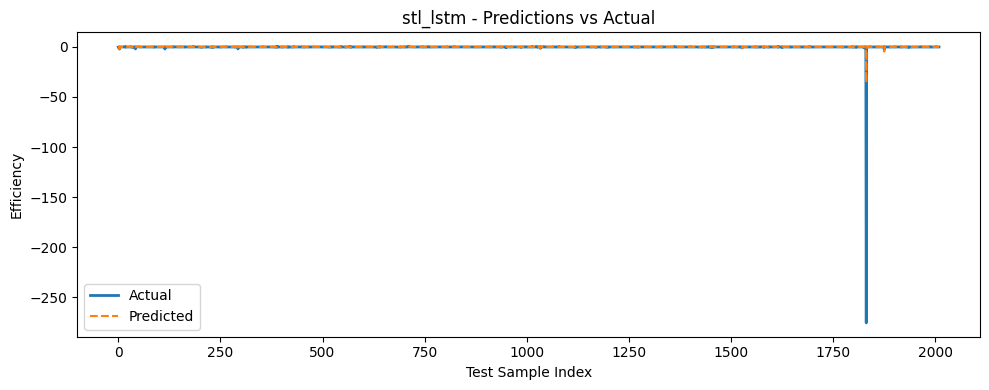

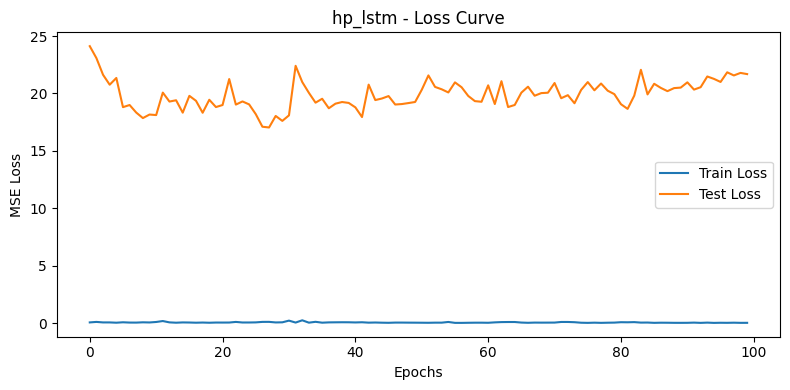

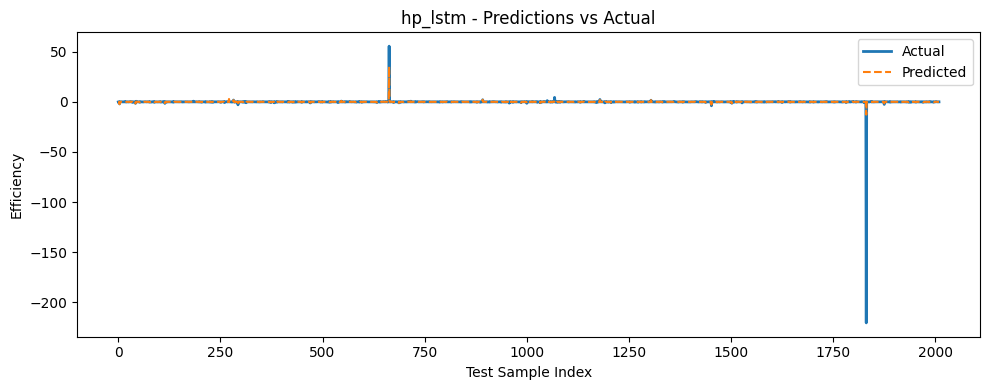

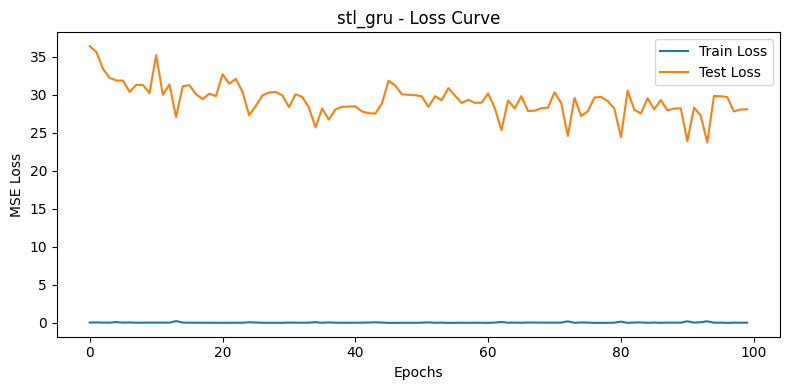

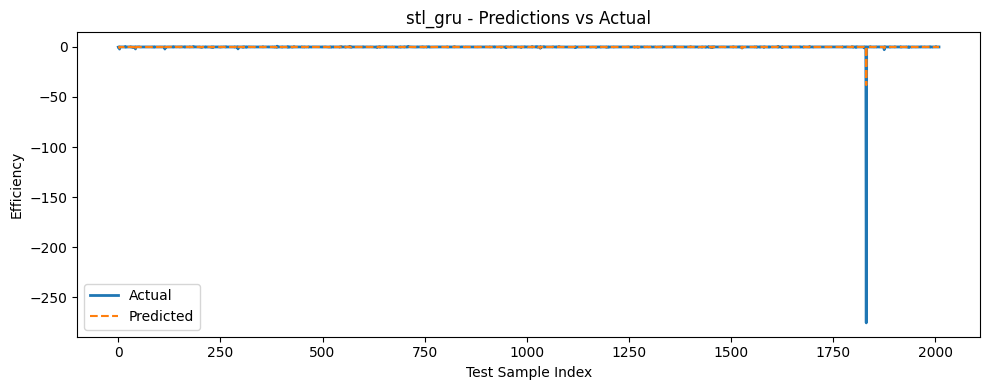

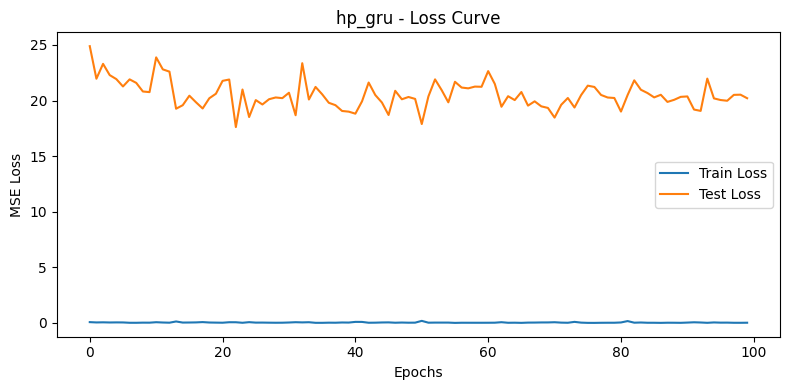

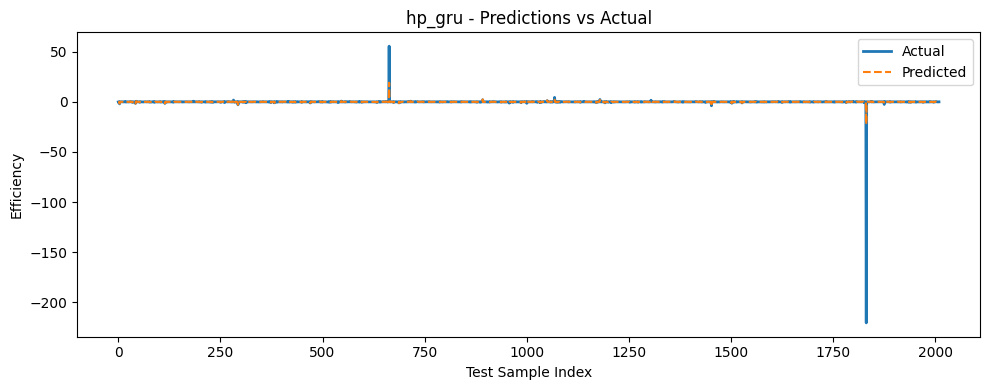

(['../visualizations/stl_rnn_loss_curve.png',
  '../visualizations/hp_rnn_loss_curve.png',
  '../visualizations/stl_lstm_loss_curve.png',
  '../visualizations/hp_lstm_loss_curve.png',
  '../visualizations/stl_gru_loss_curve.png',
  '../visualizations/hp_gru_loss_curve.png'],
 ['../visualizations/stl_rnn_pred_vs_actual.png',
  '../visualizations/hp_rnn_pred_vs_actual.png',
  '../visualizations/stl_lstm_pred_vs_actual.png',
  '../visualizations/hp_lstm_pred_vs_actual.png',
  '../visualizations/stl_gru_pred_vs_actual.png',
  '../visualizations/hp_gru_pred_vs_actual.png'])

In [100]:
import matplotlib.pyplot as plt
import os

def plot_loss_curve(train_loss, test_loss, model_name):
    plt.figure(figsize=(8, 4))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.title(f"{model_name} - Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.tight_layout()
    filename = f"../visualizations/{model_name.lower()}_loss_curve.png"
    plt.savefig(filename)
    plt.show()
    plt.close()
    return filename


def plot_pred_vs_actual(pred_csv_path, model_name):
    df = pd.read_csv(pred_csv_path)
    plt.figure(figsize=(10, 4))
    plt.plot(df["Actual"], label="Actual", linewidth=2)
    plt.plot(df["Predicted"], label="Predicted", linestyle="--")
    plt.title(f"{model_name} - Predictions vs Actual")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Efficiency")
    plt.legend()
    plt.tight_layout()
    filename = f"../visualizations/{model_name.lower()}_pred_vs_actual.png"
    plt.savefig(filename)
    plt.show()
    plt.close()
    return filename

loss_plot_paths = []
pred_plot_paths = []

for model_name in results.keys():
    metrics_path = f"../processed_data/{model_name.lower()}_metrics.csv"
    preds_path = f"../processed_data/{model_name.lower()}_predictions.csv"

    if os.path.exists(metrics_path) and os.path.exists(preds_path):
        metrics = pd.read_csv(metrics_path)
        loss_path = plot_loss_curve(metrics["train_loss"], metrics["test_loss"], model_name)
        pred_path = plot_pred_vs_actual(preds_path, model_name)
        loss_plot_paths.append(loss_path)
        pred_plot_paths.append(pred_path)

loss_plot_paths, pred_plot_paths


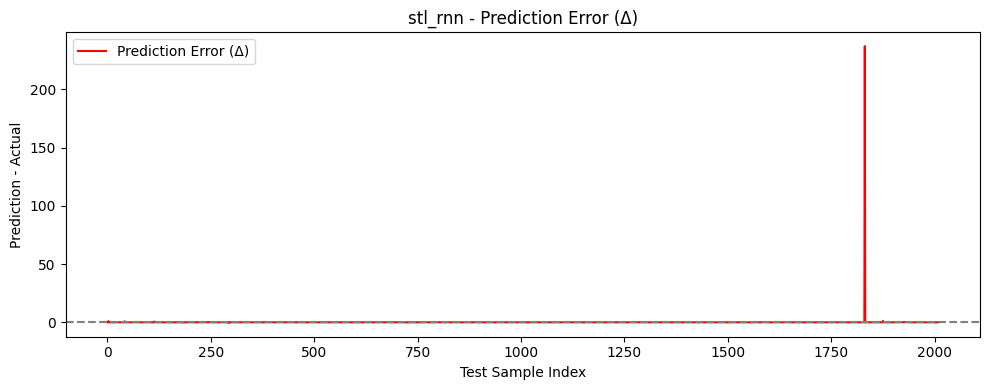

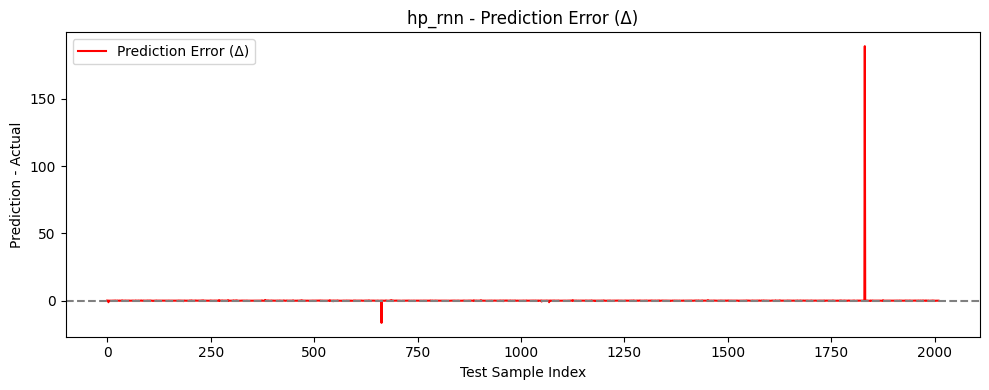

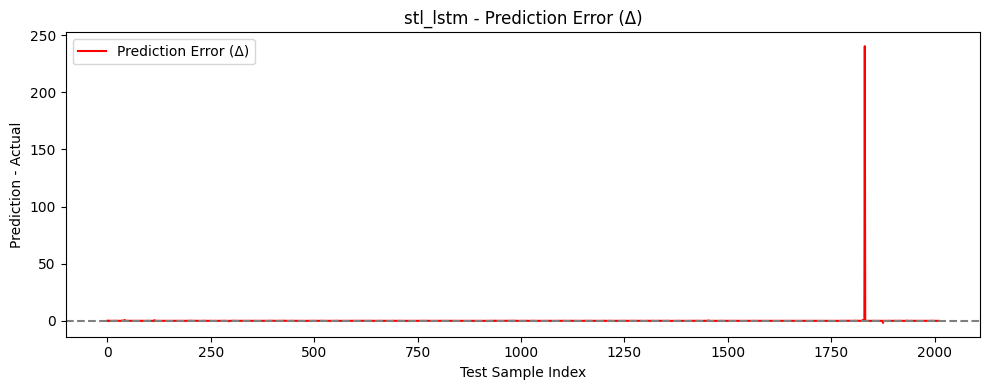

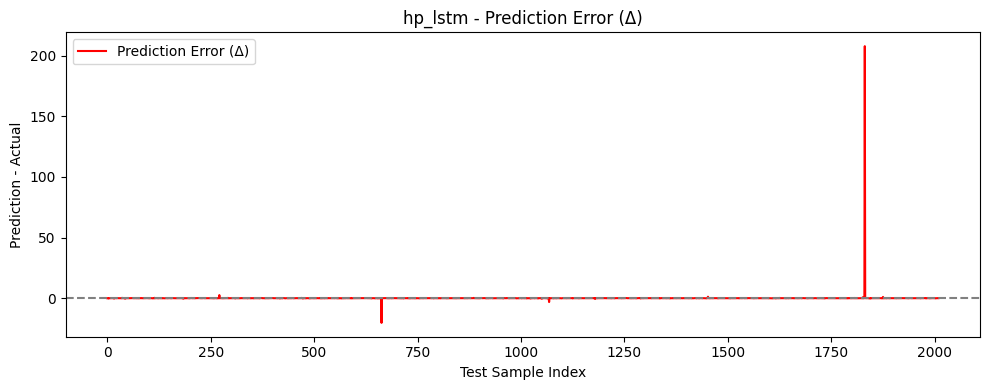

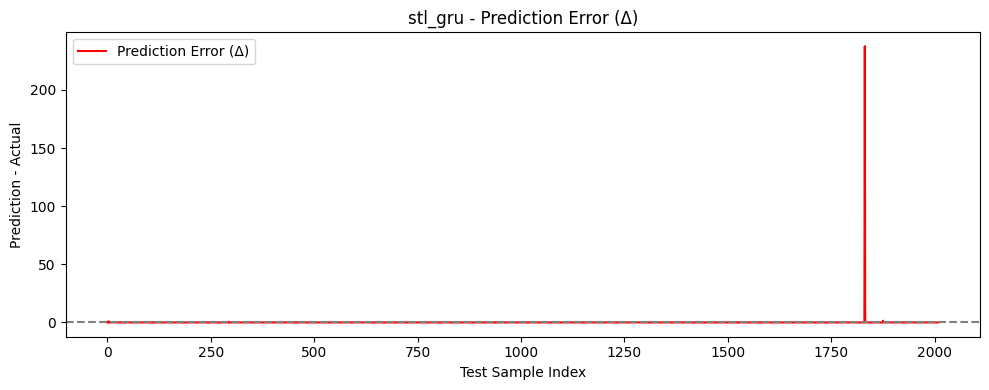

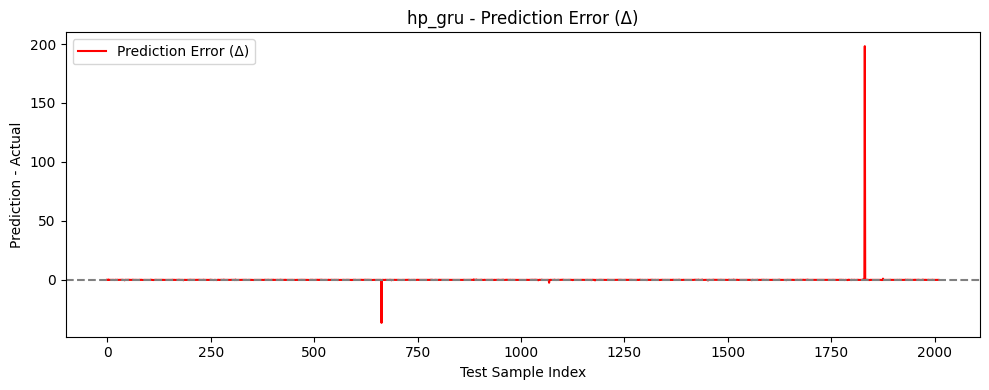

In [102]:
def plot_prediction_error(pred_csv_path, model_name):
    df = pd.read_csv(pred_csv_path)
    delta = df["Predicted"] - df["Actual"]

    plt.figure(figsize=(10, 4))
    plt.plot(delta, label="Prediction Error (Δ)", color="red")
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"{model_name} - Prediction Error (Δ)")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Prediction - Actual")
    plt.legend()
    plt.tight_layout()

    filename = f"../visualizations/{model_name.lower()}_prediction_error.png"
    plt.savefig(filename)
    plt.show()
    plt.close()
    return filename


for name in dl_models:
    plot_prediction_error(f"../processed_data/{name.lower()}_predictions.csv", name)
